In [1]:
import pandas as pd
import numpy as np
from langdetect import detect
import re

In [2]:
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
def clean_comment(text):
    wnl = WordNetLemmatizer()
    deacc = re.sub(r'\W',' ', text)
    tokens = word_tokenize(deacc)
    res = ''
    for t in tokens:
        res += wnl.lemmatize(t)+' '
    return res

In [3]:
comments = pd.read_csv('../data/comments_lang.csv')
comments_en = comments[comments.lang == 'en']
comments_en['cleaned'] = comments_en.Review.apply(clean_comment)
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vect = CountVectorizer(ngram_range = (1,1), analyzer = 'word',
                       stop_words = 'english',
                       max_features = 200,
                       min_df = 2, max_df = 0.95).fit(comments_en.cleaned)
pw = list(vect.vocabulary_.keys())

/home/lsm/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [4]:
def check_spelling(text):
    import enchant
    c = enchant.Dict("en_UK")
    if not c.check(text):
        suggestions = list(set(c.suggest(text)).intersection(set(pw)))
        if len(suggestions)>0:
            res = suggestions[0]
        else:
            res = text
    else:
        res = text
    return res

In [5]:
labeled1 = pd.read_excel('manual_labels.xlsx')
labeled2 = pd.read_excel('manual_labels2.xlsx')
labeled3 = pd.read_excel('manual_labels3.xlsx')
labeled4 = pd.read_excel('manual_labels4.xlsx')

In [6]:
labeled4.label.value_counts()

4    574
2    204
5     93
0     77
3     42
1     10
Name: label, dtype: int64

In [7]:
labeled2.shape

(1000, 5)

In [8]:
labeled1.label.value_counts()

4    624
2    203
5     74
0     60
3     31
1      8
Name: label, dtype: int64

In [9]:
def get_tokens(text):
    wnl = WordNetLemmatizer()
    deacc = re.sub(r'\W',' ', text)
    tokens = word_tokenize(deacc)
    return tokens

In [15]:
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
import nltk
from nltk.corpus import wordnet
from emoji.unicode_codes import UNICODE_EMOJI
import emoji
def get_wordnet_pos(treebank_tag):

    if treebank_tag.startswith('J'):
        return wordnet.ADJ
    elif treebank_tag.startswith('V'):
        return wordnet.VERB
    elif treebank_tag.startswith('N'):
        return wordnet.NOUN
    elif treebank_tag.startswith('R'):
        return wordnet.ADV
    else:
        return ''

def clean_comment(text):
    wnl = WordNetLemmatizer()
    #deacc = re.sub(r'\!',' exclamation_point ', text)
    tokens = word_tokenize(text)
    tags = nltk.pos_tag(tokens)
    processed = []
    for (word, tag) in tags:
        wn_tag = get_wordnet_pos(tag)
        if wn_tag!='':
            processed.append(wnl.lemmatize(word,wn_tag))
        else:
            processed.append(wnl.lemmatize(check_spelling(word)))
    return ' '.join(processed)

In [11]:
labeled = pd.concat([labeled1, labeled2, labeled3, labeled4],axis = 0)

In [12]:
labeled.loc[:,'cleaned'] = labeled.Review.apply(clean_comment)

In [13]:
labeled['tokens'] = labeled.Review.apply(get_tokens)

In [14]:
labeled_long = labeled[labeled.tokens.apply(len)>6]
labeled_neg = labeled[labeled.label!=4]

In [16]:
comments_en.loc[:,'cleaned'] = comments_en.Review.apply(clean_comment)

/home/lsm/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:537: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [17]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier, LassoCV
from sklearn.naive_bayes import BernoulliNB, MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

In [121]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
vect = CountVectorizer(ngram_range = (1,3), analyzer = 'word',
                       stop_words = 'english',
                       max_features = 10000,
                       binary = True,
                       min_df = 2, max_df = 0.95).fit(comments_en.cleaned)
feats = vect.transform(labeled.cleaned).toarray()
labels = labeled.label.as_matrix()

In [122]:
from sklearn.neural_network import BernoulliRBM
rbm = BernoulliRBM(n_components = 256)
rbm = rbm.fit(feats)
rbm_feats = rbm.transform(feats)

In [123]:
from sklearn.decomposition import PCA
pca = PCA(n_components = 5).fit(rbm_feats)
y = pca.transform(rbm_feats)

<IPython.core.display.Javascript object>


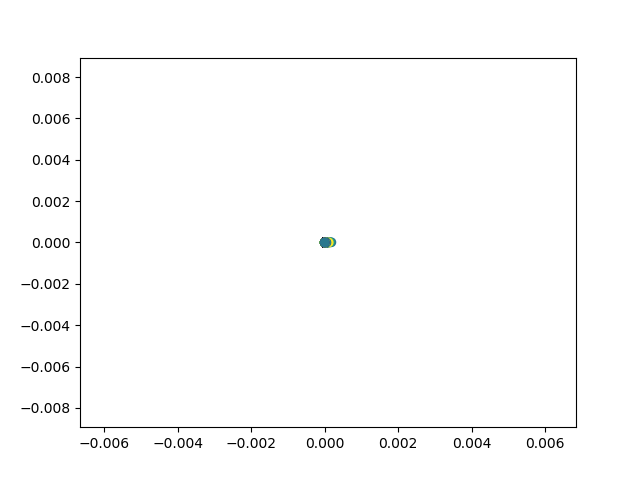

In [124]:
%matplotlib notebook
import matplotlib.pyplot as plt
colors = [int(i % 23) for i in labeled.label]
plt.scatter(y[:,0], y[:,1],c = colors)

In [125]:
def eval_model(y_train,y_test,y_train_pred,y_test_pred):
    
    class_names = ['unknown',
        'Crash',
        'Balance problems',
        'Synchronization',
        'Positive',
        'Bug']
    
    class_names_b = ['neg', 'pos']
    print('train scores\n')
    print(classification_report(y_train, y_train_pred, target_names = class_names))
    print('test scores\n')
    print(classification_report(y_test, y_test_pred, target_names = class_names))

In [126]:
feats.shape

(4000, 10000)

In [127]:
X_train, X_test, y_train, y_test = train_test_split(rbm_feats, labels, test_size=0.2)

In [128]:
m = OneVsRestClassifier(DummyClassifier()).fit(X_train, y_train)
y_train_pred = m.predict(X_train)
y_test_pred = m.predict(X_test)
eval_model(y_train,y_test,y_train_pred,y_test_pred)
print('cross_val_score: %1.4f'% (np.mean(cross_val_score(m, feats,labels))))

train scores

                  precision    recall  f1-score   support

         unknown       0.09      0.03      0.04       229
           Crash       0.00      0.00      0.00        27
Balance problems       0.28      0.09      0.14       659
 Synchronization       0.06      0.02      0.03       110
        Positive       0.61      0.57      0.59      1926
             Bug       0.08      0.34      0.13       249

     avg / total       0.44      0.39      0.40      3200

test scores

                  precision    recall  f1-score   support

         unknown       0.11      0.04      0.06        51
           Crash       0.50      0.12      0.20         8
Balance problems       0.22      0.09      0.13       141
 Synchronization       0.25      0.11      0.15        19
        Positive       0.64      0.55      0.59       509
             Bug       0.09      0.35      0.14        72

     avg / total       0.47      0.40      0.42       800

cross_val_score: 0.3792


In [129]:
m = RidgeClassifier(class_weight = 'balanced', alpha = 0.01).fit(X_train, y_train)
y_train_pred = m.predict(X_train)
y_test_pred = m.predict(X_test)
eval_model(y_train,y_test,y_train_pred,y_test_pred)
print('cross_val_score: %1.4f'% (np.mean(cross_val_score(m, feats,labels))))

train scores

                  precision    recall  f1-score   support

         unknown       0.08      0.93      0.15       229
           Crash       0.00      0.00      0.00        27
Balance problems       0.46      0.45      0.46       659
 Synchronization       0.00      0.00      0.00       110
        Positive       0.76      0.01      0.01      1926
             Bug       0.00      0.00      0.00       249

     avg / total       0.56      0.16      0.11      3200

test scores

                  precision    recall  f1-score   support

         unknown       0.08      1.00      0.15        51
           Crash       0.00      0.00      0.00         8
Balance problems       0.43      0.48      0.45       141
 Synchronization       0.00      0.00      0.00        19
        Positive       0.67      0.00      0.01       509
             Bug       0.00      0.00      0.00        72

     avg / total       0.51      0.15      0.09       800



/home/lsm/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


cross_val_score: 0.6802


In [130]:
from sklearn.metrics import f1_score,roc_auc_score,accuracy_score
def eval_classifier(input_text,model = m):
    cleaned_text = clean_comment(input_text)
    feats = vect.transform([cleaned_text])
    rbm_feats = rbm.transform(feats)
    class_names = ['Other',
        'Crash',
        'Balance problems',
        'Synchronization',
        'Positive',
        'Bug']
    prediction = model.predict(rbm_feats)
    #print(class_names[prediction[0]])
    return prediction[0]
def val_score(model):
    class_names = ['Other',
        'Crash',
        'Balance problems',
        'Synchronization',
        'Positive',
        'Bug']    
    val_en = pd.read_excel('validation_en.xlsx')
    y_true = []
    y_pred = []
    for i in range(0,6):
        y_true.append([i]*10)
        y_pred.append(val_en.iloc[:,i].apply(eval_classifier))
    y_true = np.array(y_true).flatten()
    y_pred = np.array(y_pred).flatten()
    print(classification_report(y_true, y_pred, target_names = class_names))
    return y_true,y_pred
y_true,y_pred = val_score(m)

                  precision    recall  f1-score   support

           Other       0.50      0.90      0.64        10
           Crash       0.00      0.00      0.00        10
Balance problems       0.24      1.00      0.38        10
 Synchronization       0.00      0.00      0.00        10
        Positive       0.00      0.00      0.00        10
             Bug       0.00      0.00      0.00        10

     avg / total       0.12      0.32      0.17        60



/home/lsm/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [131]:
eval_classifier('this dum gaem crashes every time i launch it')

0

In [132]:
eval_classifier('the new up date made game sooo unfair')

0

In [133]:
eval_classifier('the game glitched and all of my guns are lost!')

0

In [134]:
eval_classifier('Cool!')

0

In [135]:
eval_classifier('This game is haard to control')

0